# Установочный блок для работы в ClearML Людмилы - без нужды не трогать!!!

In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZOGXVH72IL0M6U17A058
%env CLEARML_API_SECRET_KEY=78mCNC0nCZI2Upe7mBiVfFTEO5n77SL3zkb6lIjzZJXbCgAgLh

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZOGXVH72IL0M6U17A058
env: CLEARML_API_SECRET_KEY=78mCNC0nCZI2Upe7mBiVfFTEO5n77SL3zkb6lIjzZJXbCgAgLh


# Импорты

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

from catboost import CatBoostClassifier
from catboost import Pool

import matplotlib.pyplot as plt

from clearml import Task, Logger

# Загрузка датасета

## Тренировочная выборка

In [3]:
df_train = pd.read_csv('../../data/raw/train.csv', index_col='id')

In [ ]:
df_train

In [ ]:
df_train.info()

In [ ]:
df_train.describe()

## Тестовая выборка

In [16]:
df_test = pd.read_csv('../../data/raw/test.csv', index_col='id')

In [ ]:
df_test

In [ ]:
df_test.info()

In [ ]:
df_test.describe()

## Файл результатов

In [17]:
df_label = pd.read_csv('../../data/raw/sample_submission.csv', index_col='id')

In [ ]:
df_label

## Предварительный вывод:

Всё чистенько, ничего править-заполнять не нужно, это +. Все входные параметры почти все числовые, это тоже большой +. На текущем этапе особых сложностей не заметно.

# Предварительная оценка влияния данных на результат

## Таблица корреляции

In [ ]:
def cat_num_split(df: pd.DataFrame) -> tuple:
    '''Ищем категориальные и числовые признаки в датафрейме'''

    cat_columns = []
    num_columns = []

    for column_name in df.columns:
        if (df[column_name].dtypes == object):
            cat_columns +=[column_name]
        else:
            num_columns +=[column_name]

    print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))
    print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))

    return cat_columns, num_columns

In [ ]:
cat_columns, num_columns = cat_num_split(df_train)

In [ ]:
# Смотрим что это за чудо-чудное категориальное

df_train['f_27']

**Похоже, это какая-то важная для предикции фича**

In [ ]:
corr = df_train[num_columns].corr()

In [ ]:
corr.style.background_gradient(cmap='RdYlGn')

## Предварительный вывод:

Входные признаки взаимно не коррелированы между собой, это +. Единственный категориальный признак в датасете очевидно является его изюминкой и требует большего внимания.

# Создание простенькой модели на одних числовых параметрах "навскидку", оценка метрики

In [ ]:
# Определяем имя задачи

# task = Task.init(project_name='mlops_2', task_name='Ridge_Cls_2')

In [ ]:
# Определяем перечень параметров и выгружаем их в ClearML

params = {
    'test_size': 0.33,
    'random_state': 42,
    'alpha': 1
}

# task.connect(params)

In [ ]:
X = df_train[num_columns].drop(['target'], axis=1)
y = df_train['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params['test_size'], random_state=params['random_state'])

In [ ]:
model_ridge = RidgeClassifier(alpha=params['alpha'])

model_ridge.fit(X_train, y_train)

score = model_ridge.score(X_test, y_test)

In [ ]:
# Выгружаем в ClearML результат работы модели

#task.upload_artifact(name='Model_score',
#                     artifact_object=score)

## Вывод:

Не так, чтобы прямо можно было пробовать заливать результат, но в целом лучше подбрасывания монетки. И это мы ещё категориальную "изюминку" не пробовали добавить.

# Мой любимый кошачий_бустинг

## Пробуем прогнать "навскидку" посмотреть результаты (итерации, веса и т.п.)

In [ ]:
X_cat = df_train.drop(columns = ["target"])
y_cat = df_train["target"]
features_names = list(df_train.drop(columns = ["target"]).columns)

X_train, X_test, y_train, y_test = train_test_split(X_cat,
                                                    y_cat,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
# Алгоритм требует особый подход к слеплению входных параметров
# но зато прекрасно "пережевывает" необработанные категориальные признаки

train_data = Pool(
    data=X_train, 
    label=y_train,
    cat_features=['f_27'],
    feature_names=features_names
)

eval_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=['f_27'],
    feature_names=features_names
)

In [ ]:
cat_clf = CatBoostClassifier()

cat_clf.fit(X=train_data,
            eval_set=eval_data,
           )

## Визуализируем результаты

In [ ]:
results = cat_clf.evals_result_
plt.figure(figsize=(10,7))
plt.plot(results["learn"]["Logloss"], label="Метрика на Тренировочных данных")
plt.plot(results["validation"]["Logloss"], label="Метрика на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрика")
plt.legend();

In [ ]:
def feature_importance_plotter(model: CatBoostClassifier,
                               features_names: list):
    '''Отрисовываем график распределения весов модели'''
    
    ftr_imp = model.feature_importances_/np.sum(model.feature_importances_)

    sorted = np.argsort(ftr_imp)
    ypos = np.arange(len(features_names))

    fig = plt.figure(figsize=(8, 8))
    plt.barh(ypos, ftr_imp[sorted])
    plt.xlim([0, 1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos, features_names[sorted]);

In [ ]:
feature_importance_plotter(cat_clf, np.array(features_names))

## Вывод:

Количество проходов можно накинуть, переобучения на 999 вроде бы не видно. Нужно пробовать оптимизировать гиперпараметры. Входные параметры можно попробовать оставить только значимые из таблицы.

# Оптимизация гиперпараметров - !!! ВНИМАНИЕ !!! Код повторно без очень крайней нужды не запускать !!!

In [ ]:
model = CatBoostClassifier()

In [ ]:
# Щас уже не делим на подвыборки, загоняем всё как есть

X_ = df_train[['f_30', 'f_26', 'f_21', 'f_22', 'f_28', 'f_19', 'f_25', 'f_24', 'f_02', 'f_23', 'f_01', 'f_00', 'f_20', 'f_05', 'f_29', 'f_07', 'f_14', 'f_03', 'f_11', 'f_15', 'f_06', 'f_04', 'f_10', 'f_09', 'f_27', 'f_08', 'f_17', 'f_12', 'f_18', 'f_16', 'f_13']]
y_ = df_train["target"]

features_names_ = list(X_.columns)

train_data = Pool(
    data=X_, 
    label=y_,
    cat_features=['f_27'],
    feature_names=features_names_
)


In [ ]:
# Ну, хотя бы такие. На все гиперпараметры у меня терпения не хватит
grid = {'learning_rate': [0.03, 0.1, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 5, 9, 13]}

grid_search_result = model.grid_search(grid, train_data)

In [ ]:
grid_search_result['params']

**Заскриню оптимальные гиперпараметры (оптимальные для текущего этапа)**

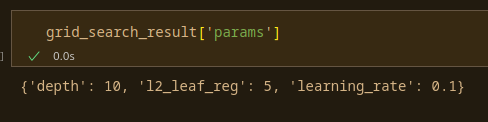

# Блок для экспериментов с моделью кошачьего_бустинга

## Определяем задачу для ClearML и необходимые параметры

In [4]:
task = Task.init(project_name='mlops_2', task_name='Catboost_X')  # <--- Вот тут вместо Catboost_x нужно каждый раз указывать новое имя для эксперимента и перезапускать среду выполнения

ClearML Task: created new task id=c2364314d4754f28b3a3be0b19b5cd02
2023-10-15 21:38:40,059 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2023-10-15 21:38:40,070 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/c97590f6d242487caa67404ef32cbad7/experiments/c2364314d4754f28b3a3be0b19b5cd02/output/log


In [8]:
params = {}

params['loss-function'] = 'Logloss'   # Выбор ф-ии потерь, варианты Logloss, Precision, F1, BalancedAccuracy and other
params['n_estimators']  = 993   # Количество решающих деревьев
params['learning_rate'] = 0.1  # Скорость обучения
params['l2_leaf_reg']   = 5     # Коэффициент L2 регуляризации
params['random_seed']   = 42    # Случайное начальное значение, используемое для обучения
params['max_depth']     = 11    # Глубина деревьев
params['test_size']     = 0.25  # Размер тестовой выборки
params['features_names'] = ['f_30', 'f_26', 'f_21', 'f_22', 'f_28',     # Перечень входных фич (названия столбцов)
                            'f_19', 'f_25', 'f_24', 'f_02', 'f_23',
                            'f_01', 'f_00', 'f_20', 'f_05', 'f_29',
                            'f_07', 'f_14', 'f_03', 'f_11', 'f_15',
                            'f_06', 'f_04', 'f_10', 'f_09', 'f_27',
                            'f_08', 'f_17', 'f_12', 'f_18', 'f_16', 'f_13'
                           ]

task.connect(params)

{'loss-function': 'Logloss',
 'n_estimators': 999,
 'learning_rate': 0.09,
 'l2_leaf_reg': 7,
 'random_seed': 42,
 'max_depth': 15,
 'test_size': 0.33,
 'features_names': ['f_30',
  'f_26',
  'f_21',
  'f_22',
  'f_28',
  'f_19',
  'f_25',
  'f_24',
  'f_02',
  'f_23',
  'f_01',
  'f_00',
  'f_20',
  'f_05',
  'f_29',
  'f_07',
  'f_14',
  'f_03',
  'f_11',
  'f_15',
  'f_06',
  'f_04',
  'f_10',
  'f_09',
  'f_27',
  'f_08',
  'f_17',
  'f_12',
  'f_18',
  'f_16']}

## Обучаем

In [6]:
X = df_train[params['features_names']]
y = df_train["target"]
features_names = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=params['test_size'],
                                                    random_state=42)

In [7]:
# Готовим Pool для Catboost

train_data = Pool(
    data=X_train, 
    label=y_train,
    cat_features=['f_27'],
    feature_names=features_names
)

eval_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=['f_27'],
    feature_names=features_names
)

In [9]:
cat_clf = CatBoostClassifier(
    loss_function=params['loss-function'],      # Все параметры мы определили выше
    n_estimators=params['n_estimators'],
    learning_rate=params['learning_rate'],
    l2_leaf_reg=params['l2_leaf_reg'],
    max_depth=params['max_depth'],
    task_type="GPU"                             # Кроме вот этого. Ежелив кто нищеброд и не имеет ГПУ, эту строчку надо стереть
    )

cat_clf.fit(X=train_data,
            eval_set=eval_data,
           )

Catboost metrics logging is not supported for GPU. See https://github.com/catboost/catboost/issues/1792
0:	learn: 0.6627491	test: 0.6634834	best: 0.6634834 (0)	total: 1.37s	remaining: 22m 45s
1:	learn: 0.6379982	test: 0.6393036	best: 0.6393036 (1)	total: 2.69s	remaining: 22m 20s
2:	learn: 0.6258916	test: 0.6279863	best: 0.6279863 (2)	total: 4.06s	remaining: 22m 28s
3:	learn: 0.6040643	test: 0.6069126	best: 0.6069126 (3)	total: 5.43s	remaining: 22m 31s
4:	learn: 0.5938658	test: 0.5973429	best: 0.5973429 (4)	total: 6.78s	remaining: 22m 27s
5:	learn: 0.5762854	test: 0.5804421	best: 0.5804421 (5)	total: 8.11s	remaining: 22m 22s
6:	learn: 0.5678776	test: 0.5725869	best: 0.5725869 (6)	total: 9.43s	remaining: 22m 16s
7:	learn: 0.5563693	test: 0.5637163	best: 0.5637163 (7)	total: 11.1s	remaining: 22m 49s
8:	learn: 0.5437138	test: 0.5514896	best: 0.5514896 (8)	total: 12.4s	remaining: 22m 42s
9:	learn: 0.5355286	test: 0.5436029	best: 0.5436029 (9)	total: 13.7s	remaining: 22m 33s
10:	learn: 0.527

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


## Картинки

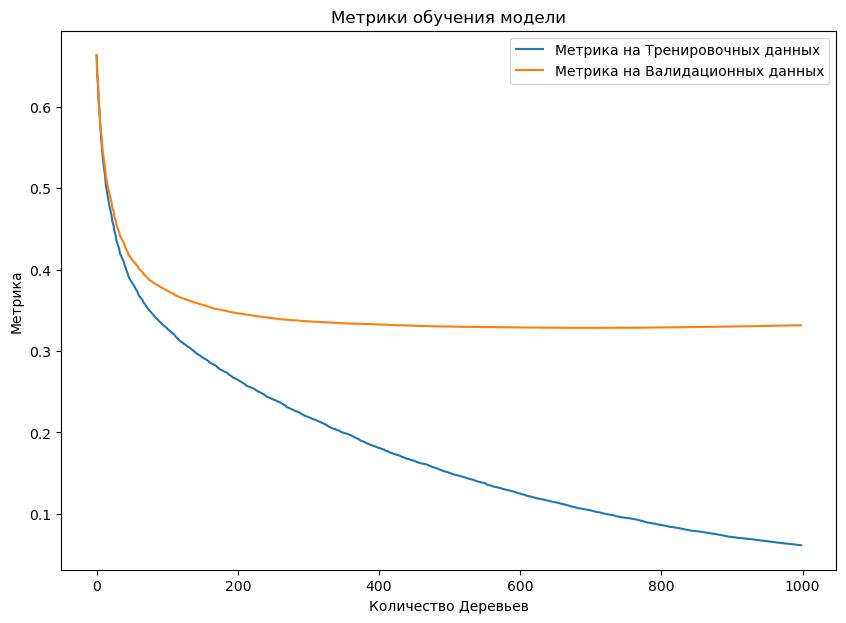

In [12]:
results = cat_clf.evals_result_
plt.figure(figsize=(10,7))
plt.plot(results["learn"][params['loss-function']], label="Метрика на Тренировочных данных")
plt.plot(results["validation"][params['loss-function']], label="Метрика на Валидационных данных")
plt.title("Метрики обучения модели")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрика")
plt.legend();
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


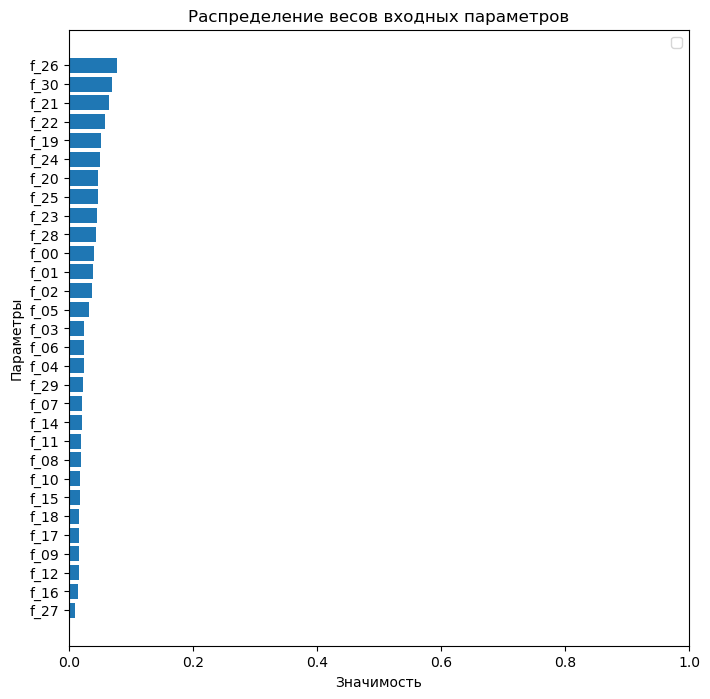

In [13]:
ftr_imp = cat_clf.feature_importances_/np.sum(cat_clf.feature_importances_)
sorted = np.argsort(ftr_imp)
ypos = np.arange(len(np.array(features_names)))

fig = plt.figure(figsize=(8, 8))
plt.barh(ypos, ftr_imp[sorted])
plt.xlim([0, 1])
plt.title('Распределение весов входных параметров')
plt.ylabel('Параметры')
plt.xlabel('Значимость')
plt.yticks(ypos, np.array(features_names)[sorted]);
plt.show()

## Выгружаем метрику модели в ClearML

In [15]:
# Выгружаем в ClearML результат работы модели

task.upload_artifact(name='Model_score',
                     artifact_object=cat_clf.evals_result_['validation'][params['loss-function']][-1])

True

# Подготовка файла с результатами по тестовой выборке для загрузки на Kaggle

In [19]:
X_ = df_test[params['features_names']]
features_names = list(X_.columns)

In [20]:
# Готовим Pool для Catboost

test_data = Pool(
    data=X_, 
    cat_features=['f_27'],
    feature_names=features_names
)

In [22]:
y_pred = cat_clf.predict(test_data)

In [23]:
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [25]:
df_label['target'] = y_pred

In [26]:
df_label

,target
id,
900000,1
900001,1
900002,0
900003,0
900004,1
...,...
1599995,0
1599996,1
1599997,0


In [28]:
df_label.to_csv('sample_submission.csv')

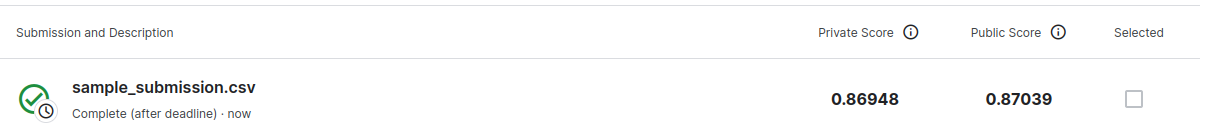